In [9]:
%run constants.ipynb

In [10]:
# Load the arguments
with open(ARGUMENTS_FILENAME, "r") as fid:
    arguments = json.load(fid)

df = pd.read_csv(arguments["dataframe_outfile"])
df["date clean"] = pd.to_datetime(df["date clean"])
df.set_index("date clean", inplace=True)
df.sort_index(inplace=True)

## Cervical mucus charting

In [14]:
# https://matplotlib.org/stable/gallery/color/named_colors.html
symbol_colors = {
    "B": "brown",  # brown bleeding
    "S": "pink",  # spotting
    "L": "salmon",  # light
    "M": "tomato",  # medium
    "H": "red",  # heavy
    "EL": "cornflowerblue",  # EL, mucus with some estrogen
    "ES": "royalblue",  # ES, mucus with high estrogen
    "G": "gray",  # dry, high in progesterone
    "U": "gold",  # unknown
}

# Create dataset where we have cycle data, so we can always pivot on day
subset = df[df["day of cycle"].notnull()]
subset["day of cycle"] = subset["day of cycle"].astype(int)

In [15]:
def lookup_color(symbol_col):
    return [
        f"background-color: {symbol_colors.get(symbol, 'white')}; color: white; font-weight: bold;"
        for symbol in symbol_col
    ]

valid_subset = subset[subset["valid_cycle"]]
table = valid_subset.pivot(
    index="nth_cycle",
    columns="day of cycle",
    values="symbol",
)

styled_table = table.style.apply(lookup_color)
styled_table

day of cycle,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
nth_cycle,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,L,M,L,L,S,S,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,G,G,G,G,G,G,G,G,G,S,nan,nan
2.0,L,L,S,S,S,G,G,U,G,G,ES,ES,ES,ES,G,ES,ES,ES,ES,G,G,G,G,G,G,G,G,G


In [16]:
# Save the charting image to the output folder
# Note: this requires installing an old version of Pillow: Pillow==9.0.0
import dataframe_image as dfi

date = datetime.datetime.now().strftime("%Y-%m-%d")
dfi.export(styled_table, f"{arguments['output_directory']}/charting_{date}.png", dpi=400)

#### With date. This way you can also add descriptions

In [17]:
def get_color(symbol_col):
    return [
        f"background-color: {symbol_colors[symbol]}; color: white; font-weight: bold;"
        if symbol in symbol_colors
        else f"background-color: white); color: black;"
        for symbol in symbol_col
    ]

table_df = valid_subset[["nth_cycle", "day of cycle", "symbol"]].reset_index()
table_df["date"] = table_df["date clean"].dt.strftime("%m/%d")
table = table_df.melt(
    id_vars=["nth_cycle", "day of cycle"],
    value_vars=["date", "symbol"],
).pivot(
    index=["nth_cycle", "variable"],
    columns="day of cycle",
    values="value",
).reset_index().sort_values("variable", ascending=False).sort_values("nth_cycle").fillna("")
table["nth_cycle"] = table["nth_cycle"].astype(int)
table.sort_values(["nth_cycle", "variable"], inplace=True)
table.set_index(["nth_cycle", "variable"], inplace=True)

styled_table = table.style.apply(get_color)
styled_table

In [18]:
date = datetime.datetime.now().strftime("%Y-%m-%d")
dfi.export(styled_table, f"{arguments['output_directory']}/charting_w_date_{date}.png", dpi=400)

## Analysis of symptoms over time

### Fatigue, a categorical variable

In [19]:
def plot_categorical_rate(
    metric: str,
    days_mean: int,
    possible_values: list[str],
    nan_is_no: bool = False,
):
    for possible_value in possible_values:
        df[f"{metric}_{possible_value}"] = (df[metric] == possible_value).astype(int)
        # assume no value means "no", if desired
        if nan_is_no and possible_value == "no":
            df.loc[df[metric].isnull(), f"{metric}_{possible_value}"] = 1

    rate_metrics = [
        f"{metric}_{possible_value}"
        for possible_value in possible_values
    ]

    fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
    for rate_metric in rate_metrics:
        if df[rate_metric].mean() == 0:
            continue

        plt.plot(
            df[rate_metric].rolling(f"{days_mean}D").mean() * 100,
            label=rate_metric.replace(f"{metric}_", ""),
        )
        fig.autofmt_xdate()

    plt.legend(title=metric.title())
    plt.title(f"{metric.title()} frequency")
    plt.ylabel(f"% of days with this type of {metric} ({days_mean}-day rolling mean)")

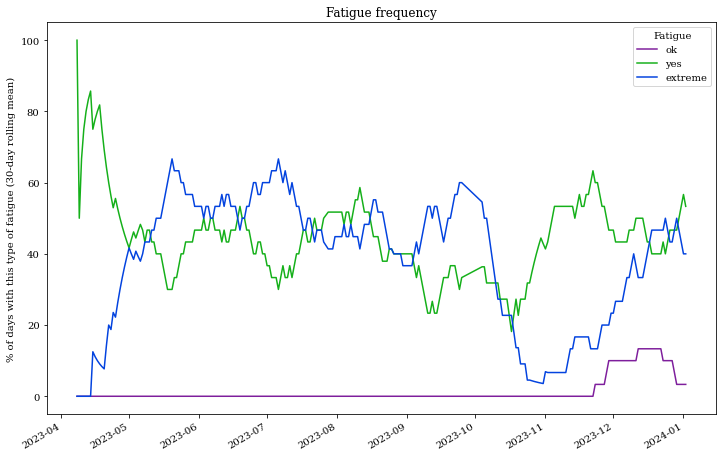

In [20]:
metric = "fatigue"
days_mean = 30
possible_values = [
    "ok",
    "no",
    "yes",
    "extreme",
    "a bit",
]

plot_categorical_rate(metric, days_mean, possible_values, nan_is_no=False)

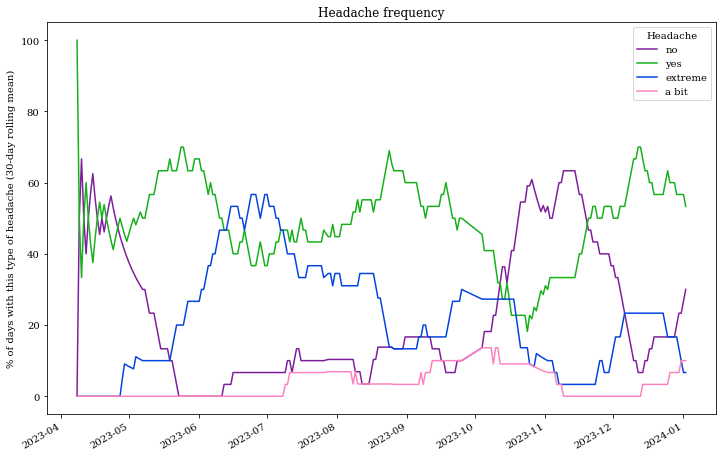

In [21]:
metric = "headache"
days_mean = 30
possible_values = [
    "no",
    "yes",
    "extreme",
    "a bit",
]

plot_categorical_rate(metric, days_mean, possible_values, nan_is_no=True)

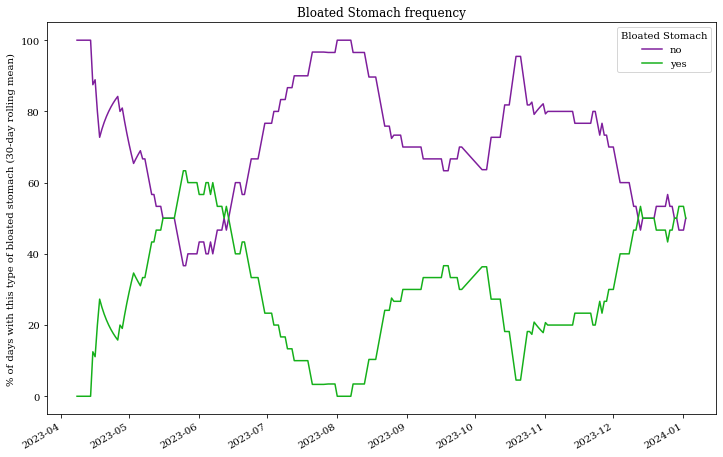

In [22]:
metric = "bloated stomach"
days_mean = 30
possible_values = [
    "no",
    "yes",
]
plot_categorical_rate(metric, days_mean, possible_values, nan_is_no=True)

### Pelvic pain: raw vs. inferred given pain medication

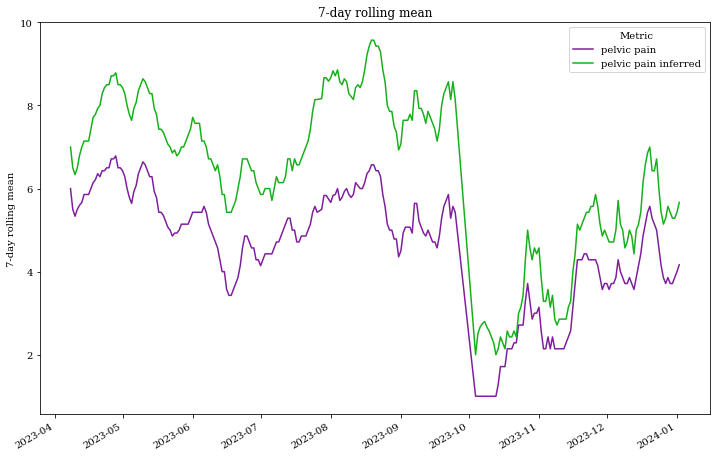

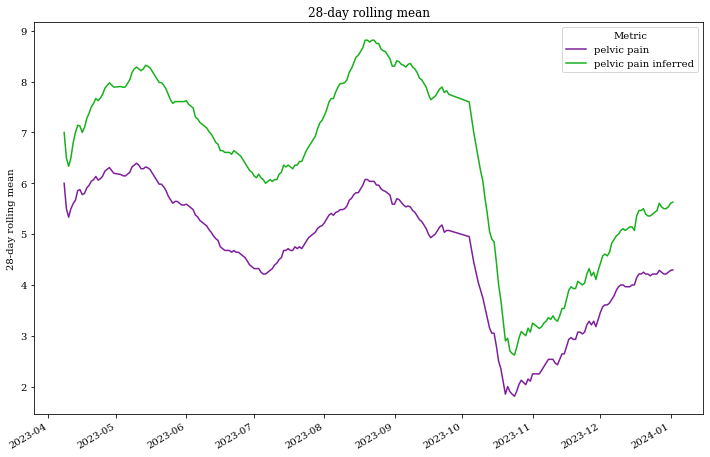

In [23]:
for days_window in [7, 28]:
    metrics = [
        "pelvic pain numeric",
        "pelvic_pain_inferred",
    ]

    fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
    for metric in metrics:
        plt.plot(
            df[metric].rolling(f"{days_window}D").mean(),
            label=metric.replace("_", " ").replace(" numeric", ""),
        )
        fig.autofmt_xdate()

    plt.legend(title="Metric")
    plt.ylabel(f"{days_window}-day rolling mean")
    plt.title(f"{days_window}-day rolling mean")

#### THC usage

Text(0.5, 1.0, '28-day rolling mean')

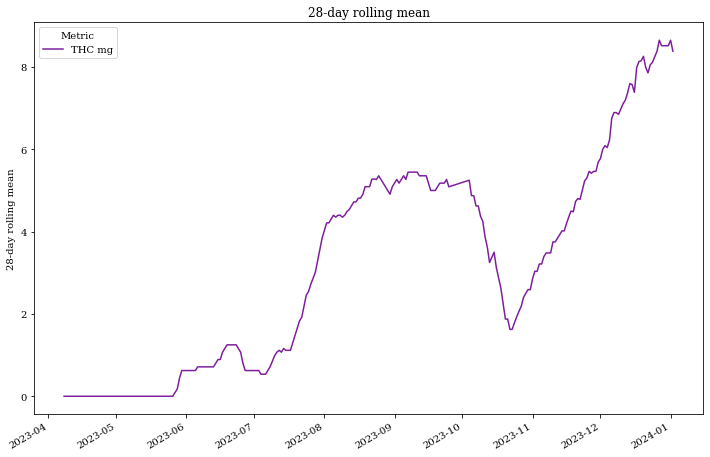

In [24]:
metric = "THC mg"
days_window = 28

fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
plt.plot(
    df[metric].rolling(f"{days_window}D").mean(),
    label=metric.replace("_", " ").replace(" numeric", ""),
)
fig.autofmt_xdate()

plt.legend(title="Metric")
plt.ylabel(f"{days_window}-day rolling mean")
plt.title(f"{days_window}-day rolling mean")

#### Sleep quality

Text(0.5, 1.0, '28-day rolling mean')

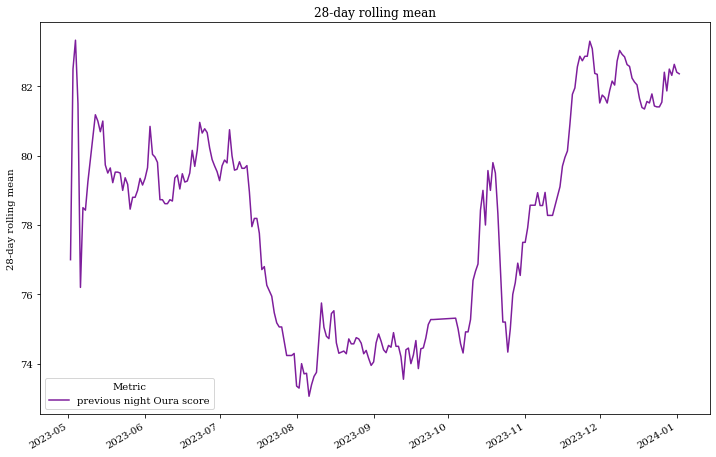

In [25]:
metric = "previous night Oura score"
days_window = 28

fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
plt.plot(
    df[metric].rolling(f"{days_window}D").mean(),
    label=metric.replace("_", " ").replace(" numeric", ""),
)
fig.autofmt_xdate()

plt.legend(title="Metric")
plt.ylabel(f"{days_window}-day rolling mean")
plt.title(f"{days_window}-day rolling mean")

In [26]:
def plot_timeline(
    metric: str,
    days_window: int,
    only_valid_cycles: bool,
):
    if only_valid_cycles:
        plot_data = df.loc[df["valid_cycle"]].copy()
    else:
        plot_data = df.copy()

    fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
    
    plt.plot(
        plot_data[metric].rolling(f"{days_window}D").mean(),
        label=metric.replace("_", " ").replace(" numeric", ""),
    )

    ## Peak day
    plotted_peak = False
    peak_days = plot_data.loc[plot_data["peak_day"] == True].index.values
    for peak_day in peak_days:
        # only make one legend label
        if plotted_peak:
            label = None
        else:
            label = "Peak Day"
            plotted_peak = True
        # approximate ovulation date, made a bit wider for visibility
        plt.axvspan(
            xmin=peak_day + np.timedelta64(-1,'D'),
            xmax=peak_day,
            color="royalblue",
            alpha=0.4,
            label=label,
        )

    ## Menstruation
    plotted_menstruation = False
    for cycle in plot_data["nth_cycle"].unique():
        if np.isnan(cycle):
            continue

        first_day_df = plot_data.loc[
            (plot_data["nth_cycle"] == cycle) &
            (plot_data["day of cycle"] == 1)
        ]

        last_day_df = plot_data.loc[
            (plot_data["nth_cycle"] == cycle) &
            plot_data["last_bleeding_day"]
        ]
        if first_day_df.empty or last_day_df.empty:
            continue
        first_day = first_day_df.index.values[0]
        last_day = last_day_df.index.values[0]

        # only make one legend label
        if plotted_menstruation:
            label = None
        else:
            label = "Menstruation"
            plotted_menstruation = True
        plt.axvspan(
            xmin=first_day,
            xmax=last_day,
            color="salmon",
            alpha=0.4,
            label=label,
        )

    fig.autofmt_xdate()

    plt.ylabel(f"{metric} {days_window}-day rolling mean")
    plt.title(f"{metric} {days_window}-day rolling mean")
    plt.legend(title="Metric/event")
    
    fig.savefig(
        f"{arguments['output_directory']}/{metric}_valid_only_{only_valid_cycles}.png",
    )

### Superimpose menstruation and ovulation

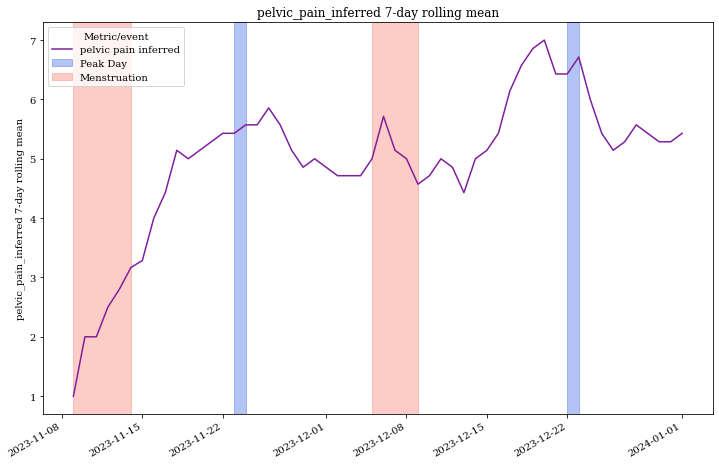

In [27]:
plot_timeline(
    metric="pelvic_pain_inferred",
    days_window=7,
    only_valid_cycles=True,  # set this to false if you want to include dates without known cycle info
)

### Plot by cycle day, rather than by date

Note that metrics are standardized.

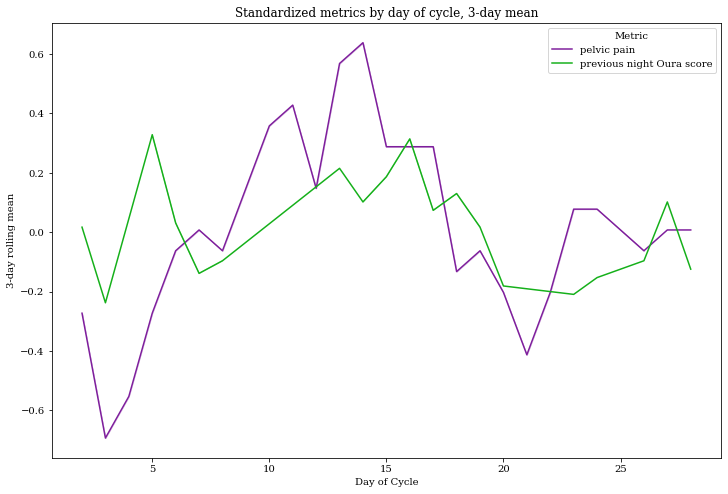

In [28]:
days_window = 3 # choose a small window to preserve information about the day

metrics = [
    "pelvic pain",
    "previous night Oura score",
]

indexed = subset.set_index("day of cycle")
indexed.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")

for metric in metrics:
    # create a standardized metric, so we can compare many at once
    indexed[f"{metric}_standardized"] = (
        (indexed[metric] - indexed[metric].mean())
        / (2 * indexed[metric].std())
    )

    # Note: confidence intervals are likely too tight b/c of high correlation among similar days of cycle
    # TODO: fit ARIMA model
    sns.lineplot(
        x=indexed.index,
        y=indexed[f"{metric}_standardized"].rolling(window=days_window).mean(),
        ci=False,
        label=metric.replace("_", " ").replace(" numeric", ""),
    )

plt.xlabel("Day of Cycle")
plt.ylabel(f"{days_window}-day rolling mean")
plt.title(f"Standardized metrics by day of cycle, {days_window}-day mean")
plt.legend(title="Metric")

## Sleep scores

I use an Oura ring to track my sleep.

Text(0.5, 1.0, 'Sleep score')

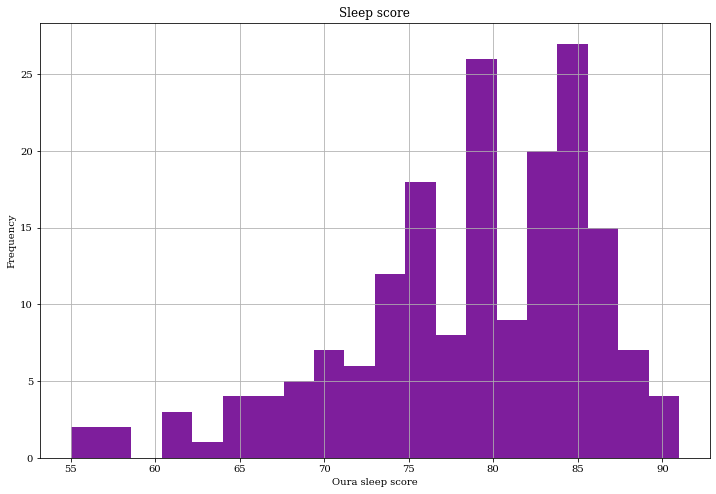

In [29]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
df["previous night Oura score"].hist(bins=20)
plt.xlabel("Oura sleep score")
plt.ylabel("Frequency")
plt.title("Sleep score")

#### Does poor sleep predict symptoms?

In [30]:
# as qualitative groups
df.loc[df["previous night Oura score"] < 80, "oura_group"] = "< 80"
df.loc[
    (df["previous night Oura score"] >= 80) &
    (df["previous night Oura score"] < 90)
, "oura_group"] = "80 - 90"
df.loc[df["previous night Oura score"] >= 90, "oura_group"] = "90+"

Text(0.5, 1.0, 'Fatigue by sleep score')

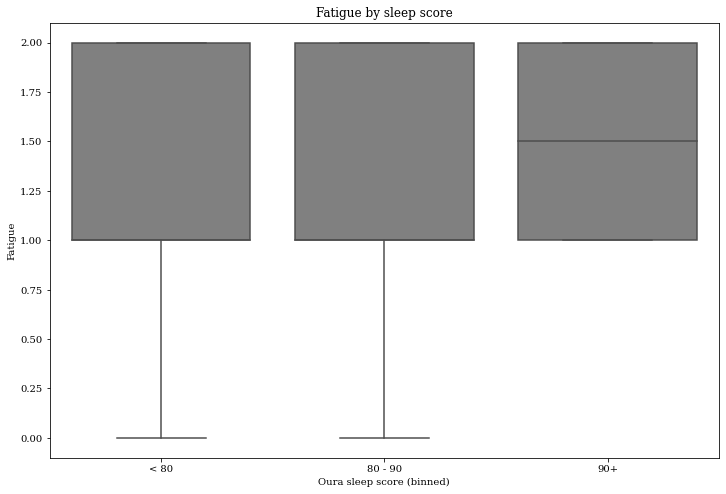

In [31]:
metric = "fatigue_numeric"
fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
sns.boxplot(
    x=df["oura_group"],
    y=df[metric],
    order=["< 80", "80 - 90", "90+"],
    color="gray",
)
metric_label = metric.replace("_", " ").replace(" numeric", "").capitalize()
plt.xlabel("Oura sleep score (binned)")
plt.ylabel(metric_label)
plt.title(f"{metric_label} by sleep score")

Text(0.5, 1.0, 'Fatigue by sleep score')

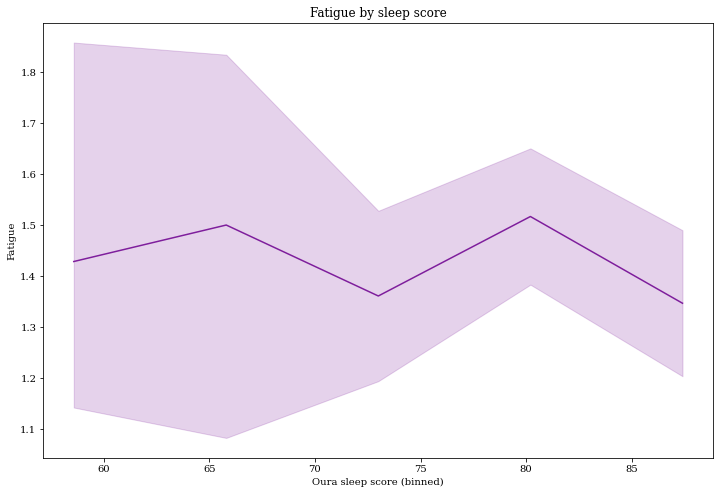

In [32]:
# quintiles
df["oura_binned"] = pd.cut(df["previous night Oura score"], bins=5).apply(lambda x: x.mid)

metric = "fatigue_numeric"
fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
sns.lineplot(
    x=df["oura_binned"],
    y=df[metric],
)
metric_label = metric.replace("_", " ").replace(" numeric", "").capitalize()
plt.xlabel("Oura sleep score (binned)")
plt.ylabel(metric_label)
plt.title(f"{metric_label} by sleep score")

## Since pain is hard to quantify, look at pain today vs. a week ago

Text(0.5, 1.0, 'pelvic pain vs. 7 days prior')

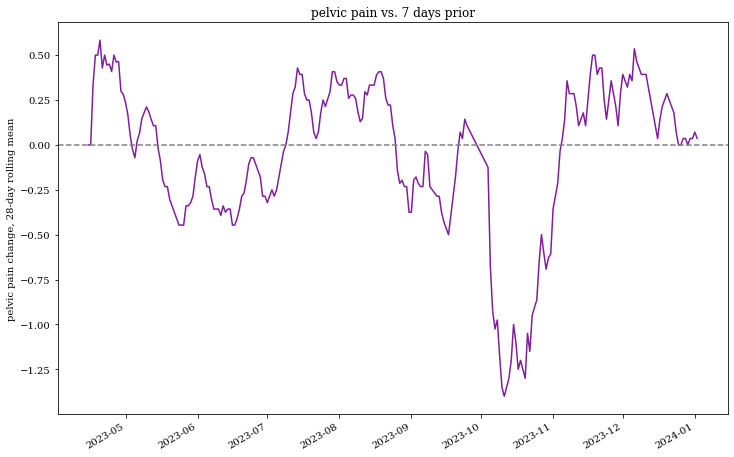

In [33]:
n_days_prior = 7
previous = df.shift(n_days_prior)

# averaging window
days_window = 28

metric = "pelvic pain numeric"
df["pelvic_pain_vs_7_days"] = (df[metric] - previous[metric])
    
fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
metric_label = metric.replace("_", " ").replace(" numeric", "")
plt.plot(
    df["pelvic_pain_vs_7_days"].rolling(f"{days_window}D").mean(),
)
plt.axhline(y=0, color="gray", linestyle="--")
plt.ylabel(f"{metric_label} change, {days_window}-day rolling mean")
fig.autofmt_xdate()
plt.title(f"{metric_label} vs. {n_days_prior} days prior")

#### Does sleep quality predict changes in pelvic pain?

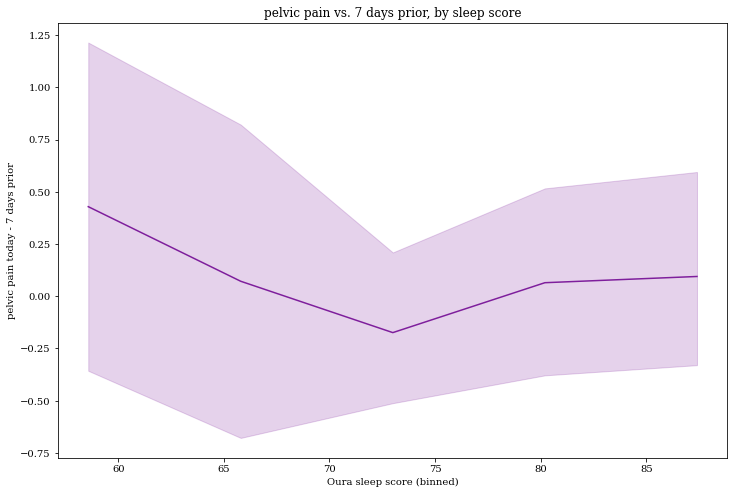

In [34]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
sns.lineplot(
    x=df["oura_binned"],
    y=df["pelvic_pain_vs_7_days"],
)
plt.xlabel("Oura sleep score (binned)")
plt.ylabel(f"{metric_label} today - {n_days_prior} days prior")
plt.title(f"{metric_label} vs. {n_days_prior} days prior, by sleep score")

fig.savefig(
    f"{arguments['output_directory']}/pelvic_pain_vs_7_days_by_sleep_score.png",
)

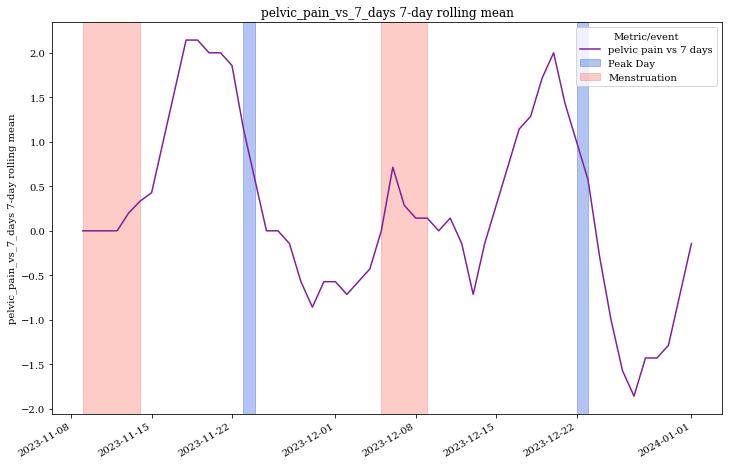

In [35]:
plot_timeline(
    metric="pelvic_pain_vs_7_days",
    days_window=7,
    only_valid_cycles=True,  # set this to false if you want to include dates without known cycle info
)

#### Does change in pain correlate with pain medication usage?

Note: I switched from Acetaminophen to THC in mid-2023.

Text(0.5, 1.0, 'THC taken by pelvic pain change')

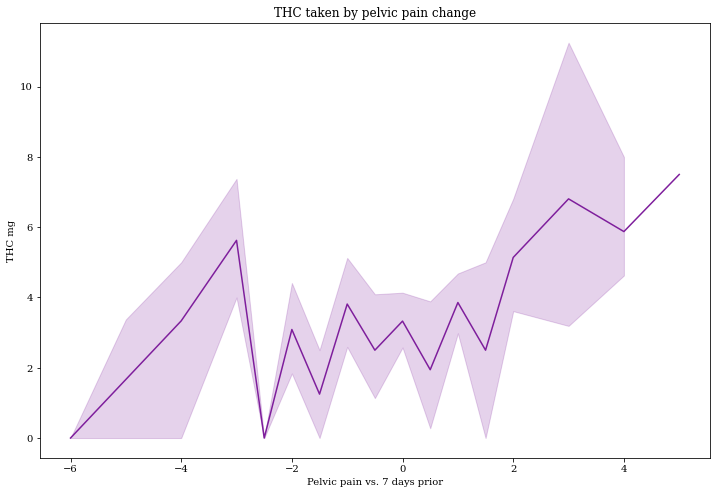

In [36]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor="w")
sns.lineplot(
    x=df["pelvic_pain_vs_7_days"],
    y=df["THC mg"],
)
plt.xlabel("Pelvic pain vs. 7 days prior")
plt.ylabel("THC mg")
plt.title("THC taken by pelvic pain change")